In [1]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error as mape

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../prophet_ver2/mergefile_drop_na.csv',skipinitialspace = True)
df.dtypes

timestamp       object
Eeg            float64
Temperature    float64
RH             float64
Windspeed      float64
cloud_cover    float64
dtype: object

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.dtypes

timestamp      datetime64[ns]
Eeg                   float64
Temperature           float64
RH                    float64
Windspeed             float64
cloud_cover           float64
dtype: object

In [4]:
df

,timestamp,Eeg,Temperature,RH,Windspeed,cloud_cover
0,2021-11-16 11:15:00,389.3058,29.3306,68.9674,1.7412,0.990000
1,2021-11-16 11:20:00,386.4714,29.2626,69.6372,1.7202,0.989667
2,2021-11-16 11:25:00,362.6794,29.2746,70.6488,1.7378,0.993667
3,2021-11-16 11:30:00,304.7228,29.2650,70.6084,1.6944,0.987500
4,2021-11-16 11:35:00,297.6544,29.2550,70.7396,1.7838,0.989000
...,...,...,...,...,...,...
2975,2021-12-16 13:40:00,667.8462,32.0638,38.0598,1.7466,0.185000
2976,2021-12-16 13:45:00,655.7560,32.3906,37.1100,1.7442,0.182000
2977,2021-12-16 13:50:00,647.5236,32.3444,37.1282,1.7116,0.180000
2978,2021-12-16 13:55:00,635.4336,32.3944,37.2276,1.7612,0.169000


In [5]:
df.corr()

,Eeg,Temperature,RH,Windspeed,cloud_cover
Eeg,1.000000,0.263522,-0.234730,0.023203,-0.327251
Temperature,0.263522,1.000000,0.218571,0.049613,-0.052136
RH,-0.234730,0.218571,1.000000,-0.021089,0.258324
Windspeed,0.023203,0.049613,-0.021089,1.000000,-0.045113
cloud_cover,-0.327251,-0.052136,0.258324,-0.045113,1.000000


In [6]:
data = df[['timestamp','Eeg','Temperature','RH','Windspeed','cloud_cover']]
data.rename(columns={'timestamp' : 'ds','cloud_cover' :'y'}, inplace=True)
data

,ds,Eeg,Temperature,RH,Windspeed,y
0,2021-11-16 11:15:00,389.3058,29.3306,68.9674,1.7412,0.990000
1,2021-11-16 11:20:00,386.4714,29.2626,69.6372,1.7202,0.989667
2,2021-11-16 11:25:00,362.6794,29.2746,70.6488,1.7378,0.993667
3,2021-11-16 11:30:00,304.7228,29.2650,70.6084,1.6944,0.987500
4,2021-11-16 11:35:00,297.6544,29.2550,70.7396,1.7838,0.989000
...,...,...,...,...,...,...
2975,2021-12-16 13:40:00,667.8462,32.0638,38.0598,1.7466,0.185000
2976,2021-12-16 13:45:00,655.7560,32.3906,37.1100,1.7442,0.182000
2977,2021-12-16 13:50:00,647.5236,32.3444,37.1282,1.7116,0.180000
2978,2021-12-16 13:55:00,635.4336,32.3944,37.2276,1.7612,0.169000


# Prepare Data

In [7]:
scaler = MinMaxScaler()
nordata = df[['Eeg','Temperature','RH','Windspeed','cloud_cover']]
normalized_data = scaler.fit_transform(nordata)
normalized_df = pd.DataFrame(normalized_data, columns=nordata.columns)
normalized_df

,Eeg,Temperature,RH,Windspeed,cloud_cover
0,0.384543,0.607617,0.635601,0.532195,0.989950
1,0.381577,0.602168,0.645935,0.494842,0.989615
2,0.356678,0.603130,0.661542,0.526147,0.993635
3,0.296024,0.602361,0.660919,0.448951,0.987437
4,0.288627,0.601559,0.662943,0.607969,0.988945
...,...,...,...,...,...
2975,0.676044,0.826625,0.158753,0.541800,0.180905
2976,0.663391,0.852811,0.144099,0.537531,0.177889
2977,0.654775,0.849109,0.144380,0.479545,0.175879
2978,0.642123,0.853116,0.145914,0.567769,0.164824


In [8]:
normalized_df['timestamp'] = df['timestamp']
normalized_df.rename(columns={'timestamp' : 'ds','cloud_cover' :'y'}, inplace=True)
normalized_df.dtypes

Eeg                   float64
Temperature           float64
RH                    float64
Windspeed             float64
y                     float64
ds             datetime64[ns]
dtype: object

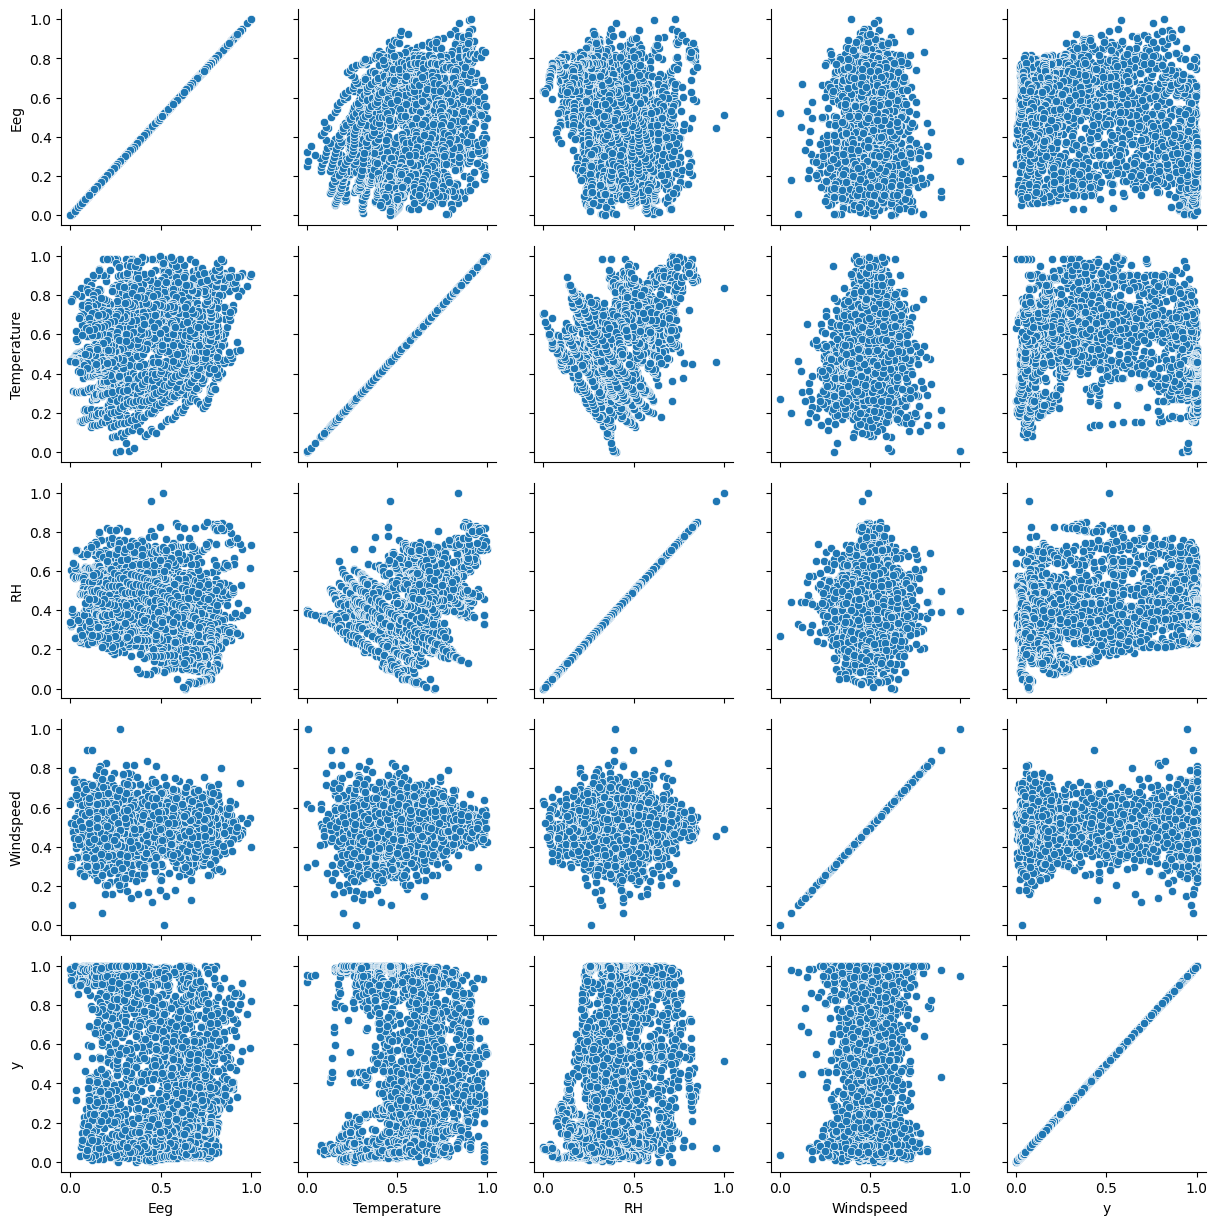

In [9]:
g = sns.PairGrid(normalized_df[["Eeg", "Temperature", "RH", "Windspeed", "y"]])
g.map(sns.scatterplot)
plt.show()

In [10]:
train = normalized_df[normalized_df['ds'] < '2021-12-16 00:00:00']
test = normalized_df[normalized_df['ds'] >= '2021-12-16 00:00:00']
print('train Shape', train.shape)
print('test Shape', test.shape)


train Shape (2921, 6)
test Shape (59, 6)


In [11]:
test1 = data[data['ds'] >= '2021-12-16 00:00:00']
print('test Shape', test1.shape)
test1

test Shape (59, 6)


,ds,Eeg,Temperature,RH,Windspeed,y
2921,2021-12-16 09:10:00,454.6010,26.3570,59.4630,1.8078,0.111
2922,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094
2923,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112
2924,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123
2925,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136
2926,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154
2927,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161
2928,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156
2929,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198
2930,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281


# Time Series Forecasting with Prophet Prediction

In [12]:
model = Prophet()
model.add_regressor('Eeg')
model.add_regressor('Temperature')
model.add_regressor('RH')
model.add_regressor('Windspeed')
model.fit(train)

22:34:26 - cmdstanpy - INFO - Chain [1] start processing
22:34:29 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
df_test = test[['ds','Eeg','Temperature','RH','Windspeed']]
df_test

,ds,Eeg,Temperature,RH,Windspeed
2921,2021-12-16 09:10:00,0.452876,0.369346,0.488966,0.650658
2922,2021-12-16 09:15:00,0.474809,0.381910,0.462405,0.648879
2923,2021-12-16 09:20:00,0.469886,0.399923,0.452885,0.731057
2924,2021-12-16 09:25:00,0.498932,0.401285,0.445032,0.571327
2925,2021-12-16 09:30:00,0.502846,0.414875,0.434856,0.233013
2926,2021-12-16 09:35:00,0.500496,0.434635,0.420193,0.571327
2927,2021-12-16 09:40:00,0.520730,0.444779,0.406477,0.541089
2928,2021-12-16 09:45:00,0.495302,0.452728,0.398887,0.395589
2929,2021-12-16 09:50:00,0.485541,0.456895,0.389543,0.575240
2930,2021-12-16 09:55:00,0.570540,0.464427,0.384616,0.598719


In [14]:
df_test1 = test1[['ds','y']]
df_test1

,ds,y
2921,2021-12-16 09:10:00,0.111
2922,2021-12-16 09:15:00,0.094
2923,2021-12-16 09:20:00,0.112
2924,2021-12-16 09:25:00,0.123
2925,2021-12-16 09:30:00,0.136
2926,2021-12-16 09:35:00,0.154
2927,2021-12-16 09:40:00,0.161
2928,2021-12-16 09:45:00,0.156
2929,2021-12-16 09:50:00,0.198
2930,2021-12-16 09:55:00,0.281


In [15]:
predict = model.predict(df_test)
predict1 = predict[['ds','yhat']]
predict1

,ds,yhat
0,2021-12-16 09:10:00,0.276082
1,2021-12-16 09:15:00,0.262887
2,2021-12-16 09:20:00,0.275592
3,2021-12-16 09:25:00,0.274274
4,2021-12-16 09:30:00,0.313879
5,2021-12-16 09:35:00,0.300776
6,2021-12-16 09:40:00,0.295624
7,2021-12-16 09:45:00,0.353780
8,2021-12-16 09:50:00,0.366717
9,2021-12-16 09:55:00,0.285420


In [16]:
final_df = pd.merge(predict1,df_test, on=['ds'])
final_df

,ds,yhat,Eeg,Temperature,RH,Windspeed
0,2021-12-16 09:10:00,0.276082,0.452876,0.369346,0.488966,0.650658
1,2021-12-16 09:15:00,0.262887,0.474809,0.381910,0.462405,0.648879
2,2021-12-16 09:20:00,0.275592,0.469886,0.399923,0.452885,0.731057
3,2021-12-16 09:25:00,0.274274,0.498932,0.401285,0.445032,0.571327
4,2021-12-16 09:30:00,0.313879,0.502846,0.414875,0.434856,0.233013
5,2021-12-16 09:35:00,0.300776,0.500496,0.434635,0.420193,0.571327
6,2021-12-16 09:40:00,0.295624,0.520730,0.444779,0.406477,0.541089
7,2021-12-16 09:45:00,0.353780,0.495302,0.452728,0.398887,0.395589
8,2021-12-16 09:50:00,0.366717,0.485541,0.456895,0.389543,0.575240
9,2021-12-16 09:55:00,0.285420,0.570540,0.464427,0.384616,0.598719


In [17]:
final = scaler.inverse_transform(final_df[['Eeg','Temperature','RH','Windspeed','yhat']])
final

array([[4.54601000e+02, 2.63570000e+01, 5.94630000e+01, 1.80780000e+00,
        2.79701267e-01],
       [4.75558600e+02, 2.65138000e+01, 5.77414000e+01, 1.80680000e+00,
        2.66572689e-01],
       [4.70854200e+02, 2.67386000e+01, 5.71244000e+01, 1.85300000e+00,
        2.79214373e-01],
       [4.98609400e+02, 2.67556000e+01, 5.66154000e+01, 1.76320000e+00,
        2.77902525e-01],
       [5.02349200e+02, 2.69252000e+01, 5.59558000e+01, 1.57300000e+00,
        3.17309849e-01],
       [5.00103400e+02, 2.71718000e+01, 5.50054000e+01, 1.76320000e+00,
        3.04272043e-01],
       [5.19438000e+02, 2.72984000e+01, 5.41164000e+01, 1.74620000e+00,
        2.99145494e-01],
       [4.95140200e+02, 2.73976000e+01, 5.36244000e+01, 1.66440000e+00,
        3.57011382e-01],
       [4.85813800e+02, 2.74496000e+01, 5.30188000e+01, 1.76540000e+00,
        3.69883176e-01],
       [5.67033600e+02, 2.75436000e+01, 5.26994000e+01, 1.77860000e+00,
        2.88993217e-01],
       [6.18474600e+02, 2.7864

In [18]:
col = final_df[['Eeg','Temperature','RH','Windspeed','yhat']]

In [19]:
switch_col = ['ds','Eeg','Temperature','RH','Windspeed','y','yhat']

In [20]:
final_in = pd.DataFrame(final,columns=col.columns)
final_in[['ds']] = final_df[['ds']]
final_in

,Eeg,Temperature,RH,Windspeed,yhat,ds
0,454.6010,26.3570,59.4630,1.8078,0.279701,2021-12-16 09:10:00
1,475.5586,26.5138,57.7414,1.8068,0.266573,2021-12-16 09:15:00
2,470.8542,26.7386,57.1244,1.8530,0.279214,2021-12-16 09:20:00
3,498.6094,26.7556,56.6154,1.7632,0.277903,2021-12-16 09:25:00
4,502.3492,26.9252,55.9558,1.5730,0.317310,2021-12-16 09:30:00
5,500.1034,27.1718,55.0054,1.7632,0.304272,2021-12-16 09:35:00
6,519.4380,27.2984,54.1164,1.7462,0.299145,2021-12-16 09:40:00
7,495.1402,27.3976,53.6244,1.6644,0.357011,2021-12-16 09:45:00
8,485.8138,27.4496,53.0188,1.7654,0.369883,2021-12-16 09:50:00
9,567.0336,27.5436,52.6994,1.7786,0.288993,2021-12-16 09:55:00


In [21]:
final_marge = pd.merge(df_test1,final_in, on=['ds'])
final_marge

,ds,y,Eeg,Temperature,RH,Windspeed,yhat
0,2021-12-16 09:10:00,0.111,454.6010,26.3570,59.4630,1.8078,0.279701
1,2021-12-16 09:15:00,0.094,475.5586,26.5138,57.7414,1.8068,0.266573
2,2021-12-16 09:20:00,0.112,470.8542,26.7386,57.1244,1.8530,0.279214
3,2021-12-16 09:25:00,0.123,498.6094,26.7556,56.6154,1.7632,0.277903
4,2021-12-16 09:30:00,0.136,502.3492,26.9252,55.9558,1.5730,0.317310
5,2021-12-16 09:35:00,0.154,500.1034,27.1718,55.0054,1.7632,0.304272
6,2021-12-16 09:40:00,0.161,519.4380,27.2984,54.1164,1.7462,0.299145
7,2021-12-16 09:45:00,0.156,495.1402,27.3976,53.6244,1.6644,0.357011
8,2021-12-16 09:50:00,0.198,485.8138,27.4496,53.0188,1.7654,0.369883
9,2021-12-16 09:55:00,0.281,567.0336,27.5436,52.6994,1.7786,0.288993


In [22]:
final_switch = final_marge.reindex(columns=switch_col)
final_switch

,ds,Eeg,Temperature,RH,Windspeed,y,yhat
0,2021-12-16 09:10:00,454.6010,26.3570,59.4630,1.8078,0.111,0.279701
1,2021-12-16 09:15:00,475.5586,26.5138,57.7414,1.8068,0.094,0.266573
2,2021-12-16 09:20:00,470.8542,26.7386,57.1244,1.8530,0.112,0.279214
3,2021-12-16 09:25:00,498.6094,26.7556,56.6154,1.7632,0.123,0.277903
4,2021-12-16 09:30:00,502.3492,26.9252,55.9558,1.5730,0.136,0.317310
5,2021-12-16 09:35:00,500.1034,27.1718,55.0054,1.7632,0.154,0.304272
6,2021-12-16 09:40:00,519.4380,27.2984,54.1164,1.7462,0.161,0.299145
7,2021-12-16 09:45:00,495.1402,27.3976,53.6244,1.6644,0.156,0.357011
8,2021-12-16 09:50:00,485.8138,27.4496,53.0188,1.7654,0.198,0.369883
9,2021-12-16 09:55:00,567.0336,27.5436,52.6994,1.7786,0.281,0.288993


In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(mode='lines', x= data['ds'], y = data["y"], name='actual'))
# fig.add_trace(go.Scatter(mode='lines', x= final_switch['ds'], y = final_switch["y"], name='Real data'))
fig.add_trace(go.Scatter(mode='lines', x=final_switch['ds'], y = final_switch["yhat"], name='forecast_prophet_predict'))


fig.update_layout(
    autosize=True,
    height=600,
    title="Prophet Model",
    xaxis_title="Date",
    yaxis_title="Cloud cover",
)


fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1.zoom",
                     step="hour",
                     stepmode="backward"),
                 dict(count=2,
                     label="2.zoom",
                     step="hour",
                     stepmode="backward"),
                dict(count=3,
                     label="3.zoom",
                     step="day",
                     stepmode="backward"),              

                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [24]:
prophet_mse_error = mean_squared_error(final_switch["y"], final_switch["yhat"], squared=True)
prophet_mape_error = mape(final_switch["y"], final_switch["yhat"])
print(f'MAPE Error : {prophet_mape_error}')
print(f'MSE Error: {prophet_mse_error}')

MAPE Error : 0.7282805573280354
MSE Error: 0.0303912368237654


---